In [1]:
import json
import numpy as np
import pandas as pd
import os
import csv
from attention import AttentionLayer
from contraction import contraction_mapping
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from keras import backend as K
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")
stop_words = set(stopwords.words('english'))

In [3]:
CURRENT_WORKING_DIR = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname("__file__")))
CORPUS_PATH = f'{CURRENT_WORKING_DIR}/../data/essay_prompt_corpus.json'
SPLIT_FILE_PATH = f'{CURRENT_WORKING_DIR}/../data/train-test-split.csv'
PRED_FILE_PATH= f'{CURRENT_WORKING_DIR}/../data/predictions.json'

In [4]:
def get_train_test_split_essays(corpus, split_scheme) -> (list, list):
    """
    :param corpus: unified data file with all the essays
    :param split_scheme: train_test_split scheme file
    :rtype: list, list
    :return: pandas dataframe of train, test split essay id, text, prompt
    """

    train_test_split_dict = {}
    test_df = pd.DataFrame(columns=['id', 'text', 'prompt'])
    train_df = pd.DataFrame(columns=['id', 'text', 'prompt'])

    # create a dict of the type: {essay_id: Tag},  where Tag = 'TRAIN' or 'TEST'
    for row in split_scheme:
        if len(row) > 0:
            essay_id = int(row[0].split('essay')[1])
            train_test_split_dict[essay_id] = row[1]

    # extract essays that match the test_train_split scheme
    for essay in corpus:
        if train_test_split_dict[int(essay['id'])] == 'TRAIN':
            train_df = train_df.append({'id': essay['id'], 'text': essay['text'], 'prompt': essay['prompt']},
                                       ignore_index=True)
        else:
            test_df = test_df.append({'id': essay['id'], 'text': essay['text'], 'prompt': essay['prompt']},
                                     ignore_index=True)
    train_df.sort_values('id', inplace=True)
    test_df.sort_values('id', inplace=True)
    return train_df, test_df

In [10]:
json_corpus = json.load(open(CORPUS_PATH, encoding='utf-8'))

# Read train_test_split and get essays from the unified corpus based on the split
with open(SPLIT_FILE_PATH, newline='', encoding='utf-8') as csvfile:
    train_test_split_file = csv.reader(csvfile, delimiter=';')
    next(train_test_split_file, None)
    train_essays, test_essays = get_train_test_split_essays(json_corpus, train_test_split_file)

In [14]:
def text_cleaner(text, num):
    """
        Performs the following on input text:
            1.Convert everything to lowercase
            2.Contraction mapping
            3.Remove (‘s)
            4.Remove any text inside the parenthesis ( )
            5.Eliminate punctuations and special characters
            6.Remove stopwords
            7.Remove short words
    """
    new_string = text.lower()
    new_string = re.sub(r'\([^)]*\)', '', new_string)
    new_string = re.sub('"', '', new_string)
    new_string = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_string.split(" ")])
    new_string = re.sub(r"'s\b", "", new_string)
    new_string = re.sub("[^a-zA-Z]", " ", new_string)
    new_string = re.sub('[m]{2,}', 'mm', new_string)
    if num == 0:
        tokens = [w for w in new_string.split() if w not in stop_words]
    else:
        tokens = new_string.split()
    long_words = []
    for i in tokens:
        if len(i) > 1:                                                 # removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [15]:
#call the function
cleaned_text = []
for t in train_essays['text']:
    cleaned_text.append(text_cleaner(t,0))

In [17]:
cleaned_text[:1]

['always said competition effectively promote development economy order survive competition companies continue improve products service result whole society prospers however discuss issue competition cooperation concerned whole society development individual whole life point view firmly believe attach importance cooperation primary education first cooperation children learn interpersonal skills significant future life students acquired team work achieve goal others importantly get along others process cooperation children learn listen opinions others communicate others think comprehensively even compromise team members conflicts occurred skills help get well people benefit whole life hand significance competition become excellence gain victory hence always said competition makes society effective however consider question win game always find need cooperation greater goal competition need take olympic games form competition instance hard imagine athlete could win game without training 

In [18]:
#call the function
cleaned_summary = []
for t in train_essays['prompt']:
    cleaned_summary.append(text_cleaner(t,1))

In [20]:
cleaned_summary[:1]

['should students be taught to compete or to cooperate']

In [21]:
train_essays['cleaned_text']=cleaned_text
train_essays['cleaned_summary']=cleaned_summary

In [23]:
train_essays.replace('', np.nan, inplace=True)
train_essays.dropna(axis=0,inplace=True)

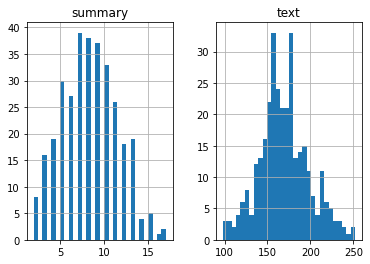

In [25]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in train_essays['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in train_essays['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [30]:
cnt=0
for i in train_essays['cleaned_summary']:
    if(len(i.split())<= 17):
        cnt=cnt+1
print(cnt/len(train_essays['cleaned_summary']))

0.9937888198757764


In [31]:
cnt=0
for i in train_essays['cleaned_text']:
    if(len(i.split())<= 252):
        cnt=cnt+1
print(cnt/len(train_essays['cleaned_text']))

1.0


In [32]:
max_text_len=252
max_summary_len=17

In [33]:
df=pd.DataFrame({'text':train_essays['cleaned_text'],'summary':train_essays['cleaned_summary']})


In [35]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [36]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [37]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [39]:

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [40]:
x_voc

2164

In [43]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer() 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [44]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(289, 289)

In [45]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [46]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [47]:
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 252)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 252, 100)     216400      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 252, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [48]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [49]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=18,
                  callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], 
                                                                  y_val.reshape(y_val.shape[0],
                                                                                y_val.shape[1], 1)[:,1:]))

Epoch 1/50
3/3 [==============================] - 11s 4s/step - loss: 3.9609 - val_loss: 3.4101
Epoch 2/50
3/3 [==============================] - 11s 4s/step - loss: 2.4832 - val_loss: 1.3123
Epoch 3/50
3/3 [==============================] - 11s 4s/step - loss: 1.4511 - val_loss: 1.3743
Epoch 4/50
3/3 [==============================] - 11s 4s/step - loss: 1.4397 - val_loss: 1.2786
Epoch 5/50
3/3 [==============================] - 11s 4s/step - loss: 1.3834 - val_loss: 1.2541
Epoch 6/50
3/3 [==============================] - 10s 3s/step - loss: 1.3766 - val_loss: 1.2359
Epoch 7/50
3/3 [==============================] - 10s 3s/step - loss: 1.3612 - val_loss: 1.2252
Epoch 8/50
3/3 [==============================] - 10s 3s/step - loss: 1.3550 - val_loss: 1.3106
Epoch 9/50
3/3 [==============================] - 10s 3s/step - loss: 1.3838 - val_loss: 1.2241
Epoch 10/50
3/3 [==============================] - 10s 3s/step - loss: 1.3523 - val_loss: 1.2458
Epoch 11/50
3/3 [======================

In [50]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [51]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [52]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [53]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString


In [56]:
for i in range(0,10):
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")

Original summary: good or 
Predicted summary:  should


Original summary: government should be for education and or not 
Predicted summary:  should


Original summary: some young their parents 
Predicted summary:  should


Original summary: and good of and your 
Predicted summary:  should


Original summary: have 
Predicted summary:  should


Original summary: do you it is good for to work 
Predicted summary:  should


Original summary: parents or should important for their 
Predicted summary:  should


Original summary: technology to people more 
Predicted summary:  should


Original summary: are in of 
Predicted summary:  should


Original summary: should be 
Predicted summary:  should


